In [ ]:
import numpy as np
import os 
import math as mt

In [ ]:
def lu_decomposition(A):
    n = A.shape[0]
    L = np.zeros((n, n))
    U = np.zeros((n, n))  
    for i in range(n):
        L[i, i] = 1.0
        for j in range(i, n):
            U[i, j] = A[i, j] - np.dot(L[i, :i], U[:i, j])
        for j in range(i+1, n):
            L[j, i] = (A[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]
    return L, U
def solve_lu(A, b):
    L, U = lu_decomposition(A)
    n = A.shape[0]
    y = np.zeros((n, 1))
    x = np.zeros((n, 1))

    # Solve Ly = b using forward substitution
    for i in range(n):
        y[i, 0] = b[i, 0] - np.dot(L[i, :i], y[:i, 0])

    # Solve Ux = y using backward substitution
    for i in range(n - 1, -1, -1):
        x[i, 0] = (y[i, 0] - np.dot(U[i, i+1:], x[i+1:, 0])) / U[i, i]
    return x

In [ ]:
def solve_linear_system(A, b):
    try:
        # Attempt to solve the system using numpy.linalg.solve()
        X = np.linalg.solve(A, b)
        return X
    except np.linalg.LinAlgError:
        # Handle the case where A is singular (not invertible)
        raise ValueError("Matrix A is singular, and the system has no unique solution.")

In [ ]:
def get_abcd(Grid_points,rho,dt,dx,d_vis,A_n,Area,u_n,p_s):
    b=np.ones((Grid_points))
    a=np.ones((Grid_points))
    c=np.ones((Grid_points-1))
    d=np.ones((Grid_points))
    
    for i in range (0,Grid_points):
        Re=(rho*u_n[i]*(mt.sqrt(4*A_n[i]/(mt.pi))))/d_vis
        if Re < 2000:
            f=64/Re
        else :
            f=0.3164*Re**-0.25 
        a[i]=((rho*Area[2*i]/dt)+(f*rho*u_n[i]*p_s[2*i]/8))
        b[i]=((rho*Area[2*i]/(2*dx)))
        d[i]=((rho*A_n[2*i]*u_n[i]/dt))  
        if i<Grid_points-1:
            c[i]=(Area[(2*i)+1]/dx)
        if i==Grid_points-1:
            mu=((rho*Area[2*i+1])-(rho*A_n[2*i+1]))/dt



    return a,b,c,d,mu       
           

In [ ]:
#for momentum equation final draft
def solve_momentum(a, b, c, d, p_star,Grid_points,mu,u_entry,p_exit):
    """
    Calculate u_star vector using the provided inputs and matrix inversion.

    Parameters:
    a (numpy.ndarray): Coefficients a_{i+1/2}^{n+1}.
    b (numpy.ndarray): Coefficients b_{i-1/2}^{n+1} & b_{i+3/2}^{n+1}.
    c (numpy.ndarray): Coefficients c_i^{n+1}.
    d (numpy.ndarray): Coefficients d_{i+1/2}^{n}.
    p_star (numpy.ndarray): Guessed pressure vector.

    Returns:
    u_star (numpy.ndarray): Calculated u_star vector.
    """
    #len of p_star is equal to length of a-1;
    # Calculate the size of the system (number of equations)
    n =Grid_points
    if n>2:
        # Initialize the coefficient matrix A and the right-hand side vector b
        A = np.zeros((n-1, n))
        Rhs=np.zeros((n-1,1))
        # Populate the coefficient matrix and the right-hand side vector
        for i in range(1,n):
            if i<n-1:
                A[i-1, i-1] =b[i-1]
                A[i-1,i] = (-1*a[i])
                A[i-1,i+1]=b[i+1]
                const = ((c[i] * p_star[i]) - (c[i-1] * p_star[i-1]) - d[i])
                Rhs[i-1,0]=const

            else:
                A[i-1, i-1] =b[i-1]
                A[i-1,i] = (-1*(a[i]-b[i]))

                const = ((c[i-1] * p_exit) - (c[i-1] * p_star[i-1]) - d[i]+ mu/2)
                Rhs[i-1,0]=const

        #print(A,Rhs) 
        Rhs[0,0]= Rhs[0,0]-(A[0,0]*u_entry)
        #print(Rhs[0,0],Rhs[n-3,0])     
        coefficient_matrix= A[:,1:n]
        #print(coefficient_matrix,Rhs)       
        u_star1=solve_linear_system(coefficient_matrix,Rhs)
        #print(solve_linear_system(coefficient_matrix,Rhs))

    return u_star1    

In [ ]:
#pressure correction coefficients:
def get(Grid_points,u_n,u_star,Area,A_n,p_s,rho,dx,dt,d_vis):
    alpha=np.zeros(Grid_points-1)
    beta=np.zeros(Grid_points-1)
    gama=np.zeros(Grid_points-1)
    z=np.zeros(Grid_points-1)
    if (Grid_points>1): 
        for i in range(1,(2*Grid_points)-2,2):
            Re_left=(rho*u_n[(i-1)//2]*(mt.sqrt(4*A_n[i-1]/(mt.pi))))/d_vis
            Re_right=(rho*u_n[(i+1)//2]*(mt.sqrt(4*A_n[i+1]/(mt.pi))))/d_vis

            if Re_left < 2000:
                f_left=64/Re_left
            else :
                f_left=0.3164*Re_left**-0.25

            if Re_right < 2000:
                f_right=64/Re_right
            else :
                f_right=0.3164*Re_right**-0.25 

            a_left=(rho*Area[i-1]/dx)
            b_left=(rho*Area[i-1]/dt)
            c_left=(f_left*rho*u_n[(i-1)//2]*p_s[i-1]/8) //2
            a_right=(rho*Area[i+1]/dx)
            b_right=(rho*Area[i+1]/dt)
            c_right=(f_right*rho*u_n[(i+1)//2]*p_s[i+1]/8)

            beta1_left=(a_left/(b_left+c_left))
            gama1_right=(a_right/(b_right+c_right))

            alpha[(i-1)//2]=(beta1_left+gama1_right)*(Area[i]/dx)
            beta[(i-1)//2]=beta1_left*(Area[i]/dx)
            gama[(i-1)//2]=gama1_right*(Area[i]/dx)
            z[(i-1)//2]=((a_left*(u_star[(i-1)//2]))-(a_right*(u_star[(i+1)//2]))+(((rho*A_n[i])-(rho*Area[i]))/dt))

            
    return alpha,gama,beta,z


In [ ]:
def Combine(u_star1,u_star,Grid_points):
    u_star1=u_star1.reshape(1,Grid_points-1)
    u_star[1:Grid_points]=u_star1[:, :]
    return u_star

In [ ]:
def add(p_star,p_add,Grid_points):
    p_add=p_add.reshape(Grid_points-1)
    p_star[0:Grid_points-1] += p_add[0:Grid_points-1]
    return p_star

In [ ]:
def correct_pressure(Grid_points,alpha,beta,gama,z,p_exit,c_1,c_2,z1,beta_boundary):
    """
    Calculate P' vector using the provided inputs and matrix inversion.

    Parameters:
    alpha (numpy.ndarray):
    beta (numpy.ndarray): 
    gama (numpy.ndarray):
    z(numpy.ndarray):

    Returns:
    p' (numpy.ndarray): Calculated p'(It is the value of p that has to be added) vector.
    """
    n=Grid_points
    A1 = np.zeros((n-1, n))
    Rhs1=np.zeros((n-1,1))
    #populate the coefficent matrix
    A1[0,0] =c_1
    A1[0,1] = -1*c_2
    const = (z1)
    Rhs1[0,0]=const

    for i in range(1,n-1):
        if i<n-1:
            A1[i,i-1] = gama[i-1]
            A1[i,i] = (-1*alpha[i-1])
            A1[i,i+1]= (beta[i-1])
            const = (-1*z[i-1])
            Rhs1[i,0]=const
        if i==n-1:
            A1[i,i-1] = gama[i-1]
            A1[i,i] = (-1*alpha[i-1])
            A1[i,i+1]= beta_boundary
            const = (-1*z[i-1])
            Rhs1[i,0]=const

    #print(A1,Rhs1)    
    Rhs1[n-2,0]=Rhs1[n-2,0]-(A1[n-2,n-1]*p_exit)
    co_efficientmatrix1=A1[:,0:n-1] 
    #print(co_efficientmatrix1,Rhs1)
    p_=solve_lu(co_efficientmatrix1,Rhs1)    
    return p_


In [ ]:
def Momentum(p_star,u_n,Grid_points,rho,dt,dx,d_vis,A_n,Area,p_s,u_inlet,p_exit):
    """    
    #Mometum equation part 
    """
    a_values,b_values,c_values,d_values,mu=get_abcd(Grid_points,rho,dt,dx,d_vis,A_n,Area,u_n,p_s)#solve co-efficients at all grid points
    #print(u_n)
    #define Boubdary conditions for velocity
    u_star1= solve_momentum(a_values, b_values, c_values, d_values, p_star,Grid_points,mu,u_inlet,p_exit)# Solve momentum equation to find intermediate velocity (u_star)
    #print(u_n)
    #print(u_star,u_star1)
    u_temp= u_n.copy()
    u_star=Combine(u_star1,u_temp,Grid_points)
    #print(u_n,'at combine')
    #print(u_star)
    return u_star

In [ ]:
def Pressure_adjust(p_star,u_star,Grid_points,u_n,Area,A_n,p_s,rho,dx,dt,d_vis,u_inlet,p_exit):

    """    
    Pressure Adjustment part 
    """    
    alpha,beta,gama,z=get(Grid_points,u_n,u_star,Area,A_n,p_s,rho,dx,dt,d_vis) 
    #print(alpha,beta,gama,z)
    #print(alpha.size)

    """
    Inlet boundary equation co-efficinets 
    """

    Re_inlet=(rho*u_n[2]*(mt.sqrt(4*A_n[2]/(mt.pi))))/d_vis
    if Re_inlet < 2000:
        f_inlet=64/Re_inlet
    else :
        f_inlet=0.3164*Re_inlet**-0.25 

    mu1=((rho*Area[1])-(rho*A_n[1]))/dt
    mu2=((rho*Area[3])-(rho*A_n[3]))/dt
    u2= (((rho*Area[0])/dx)*u_inlet-(mu1))/((rho*Area[2])/dx)
    u3=(((rho*Area[0])/dx)*u_inlet-(mu1+mu2))/((rho*Area[4])/dx)
    a1=((rho*Area[2]/dt)+(f_inlet*rho*u_n[2]*p_s[2]/8))
    b0=(rho*Area[0]/(2*dx))
    b2=(rho*Area[4]/(2*dx))
    c_1=(Area[1]/dx)
    c_2=(Area[3]/dx)
    z1=a1*(u2-u_star[1])-b0*(u_inlet-u_star[0])-b2*(u3-u_star[2])


    """
    The equation is c_1p1'- c_2p2'= z1
    """
    Re_boundary=(rho*u_n[Grid_points-1]*(mt.sqrt(4*A_n[2*Grid_points-2]/(mt.pi))))/d_vis
    if Re_boundary < 2000:
        f_boundary=64/Re_boundary
    else :
        f_boundary=0.3164*Re_inlet**-0.25 

    x_1B_exit=(rho*Area[2*Grid_points-2]/dx)
    x_2B_exit=(rho*Area[2*Grid_points-2]/dt)
    x_3B_exit=(f_boundary*rho*u_n[Grid_points-1]*p_s[2*Grid_points-2]/8)
    
    beta_boundary=(x_1B_exit/(x_2B_exit+x_3B_exit))*(Area[2*Grid_points-1]/dx)
    add_p1=correct_pressure(Grid_points,alpha,beta,gama,z,p_exit,c_1,c_2,z1,beta_boundary)#Solve pressure correction equation 
    #print(add_p1)
    return add_p1 


In [ ]:
def get_lamda_m_u(Grid_points,rho,Area,A_n,dx,dt):
    lamda=np.zeros((Grid_points+1))
    m_u=np.zeros((Grid_points))
    for i in range (0,len(lamda)):
        lamda[i]=(rho*Area[2*i])/dx
    for j in range (0,len(m_u)):
        m_u[j]=(rho*(Area[2*j+1]-A_n[2*j+1]))/dt    
    
    return lamda, m_u

In [ ]:
def convergence(u_star,Grid_points,rho,Area,A_n,dx,dt):
    lamda,m_u=get_lamda_m_u(Grid_points,rho,Area,A_n,dx,dt)
    residue=np.zeros((Grid_points-1))
    for i in range(0,len(residue)):
        residue[i]=(lamda[i+1]*u_star[i+1])-(lamda[i]*u_star[i])+(m_u[i])
    mean= np.mean(np.abs(residue))
    #squared_differences = (residue - mean_with_mod) ** 2
    #mean_squared_error = squared_differences.mean()
    #rmse = np.sqrt(mean_squared_error)
    return mean

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_numpy_vector(vector):
    # Check if the input is a NumPy array or can be converted to one
    if not isinstance(vector, np.ndarray):
        try:
            vector = np.array(vector)
        except:
            raise ValueError("Input is not a valid NumPy array or convertible to one.")

    # Create an array of indices based on the length of the input vector
    indices = np.arange(len(vector))

    # Plot the vector values against the indices
    plt.plot(indices, vector)
    plt.xlabel('Index')
    plt.ylabel('Velocity')
    plt.title('Plot of NumPy Vector')
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_numpy_pressure(vector):
    # Check if the input is a NumPy array or can be converted to one
    if not isinstance(vector, np.ndarray):
        try:
            vector = np.array(vector)
        except:
            raise ValueError("Input is not a valid NumPy array or convertible to one.")

    # Create an array of indices based on the length of the input vector
    indices = np.arange(len(vector))

    # Plot the vector values against the indices
    plt.plot(indices, vector)
    plt.xlabel('Index')
    plt.ylabel('pressure')
    plt.title('Plot of NumPy Vector')
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rows_separately(matrix):
    # Get the number of rows and columns in the matrix
    num_rows, num_columns = matrix.shape

    # Iterate through each row and plot it separately
    for i in range(num_rows):
        row = matrix[i, :]
        
        # Check if the row is not all zeroes
        if np.any(row):
            plt.plot(range(num_columns), row, label=f'Row {i}')
    
    plt.xlabel('Index')
    plt.ylabel('Velocity')
    #plt.legend()
    plt.title('Rows on the Same Graph')
    plt.show()

In [ ]:
# simple algorithm 
def unsteady_1D_flow(A_n,A,u_n,p_star,p_s,Grid_points,rho,dx,dt,d_vis,n,u_inlet,p_exit):
    for t in range(0,n):
        Area=np.full((2 * Grid_points + 1), A)
        #u_n and u_star is same here
        dynamic_list = []
        u_star=Momentum(p_star,u_n,Grid_points,rho,dt,dx,d_vis,A_n,Area,p_s,u_inlet,p_exit)
        converge=convergence(u_star,Grid_points,rho,Area,A_n,dx,dt)
        #plot_numpy_vector(u_star)
        print(p_star[len(p_star)-1])
        plot_numpy_pressure(p_star)

        while(converge>0.01):
            p_add=Pressure_adjust(p_star,u_star,Grid_points,u_n,Area,A_n,p_s,rho,dx,dt,d_vis,u_inlet,p_exit)
            p_star=add(p_star,p_add,Grid_points) #update the pressure
            u_star=Momentum(p_star,u_n,Grid_points,rho,dt,dx,d_vis,A_n,Area,p_s,u_inlet,p_exit)
            print(p_star[len(p_star)-1])
            plot_numpy_vector(u_star)
            converge=convergence(u_star,Grid_points,rho,Area,A_n,dx,dt)
            dynamic_list.append(u_star)
            print(converge)
        print(p_star[len(p_star)-1])   
        u_n= u_star
        print("Before next time step")
        # Convert the list of u_star vectors to a 2D NumPy array
        if dynamic_list:  # Check if the list is not empty
            dynamic_array = np.vstack(dynamic_list)
        else:
            dynamic_array = np.empty((0, len(u_star)))  # Create an empty 2D array
        #plot_rows_separately(dynamic_array)
    return u_star,p_star

In [ ]:
# Define constants and parameters

"""
const paramers through-out the analysis
All units are taken in SI system (Kilogram,Meter,Second)
d=15.4 mm
l=2 m
inletmassflux=900 kg/m^2.s
p_exit=1 atm

"""
Total_time=1
dt = 0.01  # Time step size
#n = int(Total_time/dt) # Number of time steps
n=2
rho = 996.550 # Density kg/m3
g = 9.8   # Gravitational acceleration m/s2
Grid_points=100 #Total number of grid points (Velocity faces)
Inletmassflux=900 #kg/m2.s
P_atm=1 #atm
dia=0.0154 #m
d_vis=0.000854 #Ns/m2

p_exit= P_atm* 101325 #N/m2
A= (mt.pi)*(dia**2)/4 #m2
u_inlet= Inletmassflux/(rho) #m/s
length=2 #m
#print(Re)
dx = length/Grid_points # Spatial grid size
"""
Variables w.r.t time
"""
# Initialize arrays for velocity (u) and pressure (p) at staggered grid locations
u_n = np.zeros(Grid_points) # Velocity at faces
p_star = np.zeros(Grid_points) # pressure at cell centers
A_n = np.full((2 * Grid_points + 1), A)
perimeter= (mt.pi)*dia
p_s=np.full((2 * Grid_points + 1), perimeter)
dp= 128*d_vis*length*A*u_inlet/((mt.pi)*dia**4) #pressure change between for end points


"""Initialize the pressure 
"""
p_star[len(p_star)-1]=p_exit
for i in range(len(p_star)-2,-1,-1):
    p_star[i]=p_exit

"""Initialize the velocity 
"""
u_n[0]=u_inlet
for i in range(1,len(u_n)):
    u_n[i]=0.01    

"""Intialize friction factor 
Re=(rho*u_inlet*dia)/d_vis
if Re < 2000:
    f=64/Re
else :
    f=0.3164*Re**-0.25 
"""
plot_numpy_vector(u_n)
#print(dp)
#print(p_star.shape ,u_n.shape)


"""
Final result 
"""
velocity, Pressure =unsteady_1D_flow(A_n,A,u_n,p_star,p_s,Grid_points,rho,dx,dt,d_vis,n,u_inlet,p_exit)
#peace software 




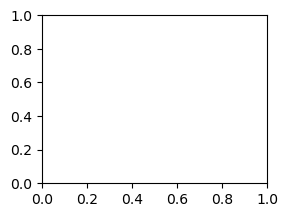

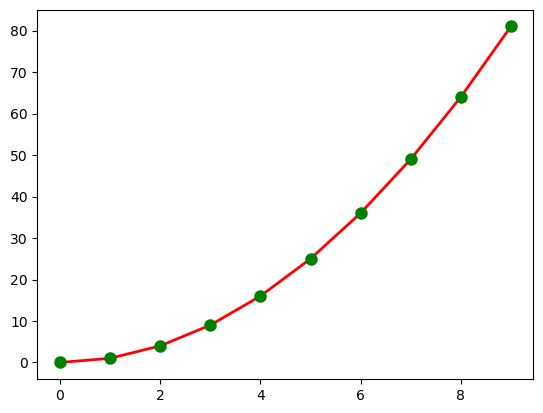

In [54]:
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.add_subplot(221)


fig=plt.figure()
x=np.arange(0,10,1)
plt.plot(x,x**2,color='r',linewidth=2,linestyle='-',label='x^2',alpha=1.0,marker='o',markersize=5,markerfacecolor='g',markeredgewidth=4,markeredgecolor='g')



 